# This file generates the cleaned data for analysis of new liquor establishments on crime or violent crime
## Also plots some maps and other useful graphs used in the report

In [1]:
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from shapely.geometry import Point, Polygon
import math
import geopy
import geopy.distance
from geopy.distance import geodesic, great_circle

In [34]:
# Key settings to vary in generating the data
num_months = 3
radius = 0.4 # in kilometers
only_violent_crimes = True

In [4]:
bl = pd.read_csv("Business_Licenses.csv")
bl = bl[["LATITUDE", "LONGITUDE", "LICENSE ID", "LICENSE DESCRIPTION", "BUSINESS ACTIVITY", "APPLICATION TYPE", "DATE ISSUED"]]

C:\Users\patri\AppData\Local\Temp\ipykernel_16324\283549513.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  bl = pd.read_csv("Business_Licenses.csv")


In [9]:
liquor_issuances = bl[bl['BUSINESS ACTIVITY'].str.contains('sale', case=False) & 
   (bl['BUSINESS ACTIVITY'].str.contains('Liquor', case=False) | bl['LICENSE DESCRIPTION'].str.contains('Liquor', case=False)) 
   & bl['APPLICATION TYPE'].str.contains('ISSUE', case=False)].drop_duplicates(subset='LATITUDE', keep="first").dropna().reset_index(drop=True)
liquor_issuances["DATE ISSUED"] =  pd.to_datetime(liquor_issuances["DATE ISSUED"], format="%m/%d/%Y")
# should not look at units within at least 7 months since we don't have crime data for then. Do 9 months to be safe.
liquor_issuances = liquor_issuances[liquor_issuances['DATE ISSUED'] < datetime.now() + relativedelta(months=-9)]

In [10]:
liquor_issuances 

,LATITUDE,LONGITUDE,LICENSE ID,LICENSE DESCRIPTION,BUSINESS ACTIVITY,APPLICATION TYPE,DATE ISSUED
5,41.945191,-87.804997,2830674,Package Goods,Retail Sales of Packaged Liquor | Retail Sales...,ISSUE,2022-03-08
15,41.900892,-87.626223,2670535,Outdoor Patio,Sale of Liquor Outdoors on Private Property,ISSUE,2019-11-04
16,41.917676,-87.687266,2464928,Outdoor Patio,Sale of Liquor Outdoors on Private Property,ISSUE,2016-07-13
18,41.866497,-87.707338,1938575,Package Goods,Retail Sales of Packaged Liquor,ISSUE,2009-05-15
20,41.948736,-87.657923,1352301,Outdoor Patio,Sale of Liquor Outdoors on Private Property,ISSUE,2004-09-07
...,...,...,...,...,...,...,...
1830,41.918206,-87.725958,2476605,Package Goods,Retail Sales of General Merchandise and Non-Pe...,ISSUE,2016-11-28
1831,41.866552,-87.702077,2355291,Package Goods,Retail Sales of Packaged Liquor,ISSUE,2015-03-17
1832,41.851163,-87.724173,2428967,Package Goods,Retail Sales of Packaged Liquor,ISSUE,2016-06-20
1834,41.939310,-87.718540,1873282,Package Goods,Retail Sales of Packaged Liquor,ISSUE,2008-05-30


In [12]:
crimes = pd.read_csv("Crimes_2001_to_Present.csv")
crimes = crimes[["Primary Type", "Date", "Latitude", "Longitude", "Community Area"]]
crimes['Date']= pd.to_datetime(crimes['Date'])
crimes = crimes.dropna()
if only_violent_crimes:
    crimes = crimes[crimes['Primary Type'].isin(['BATTERY', 'THEFT', 'ASSAULT', 'ROBBERY',
         'CRIM SEXUAL ASSAULT', 'ARSON',  'KIDNAPPING','CRIMINAL SEXUAL ASSAULT','HOMICIDE'])]
crimes

,Primary Type,Date,Latitude,Longitude,Community Area
0,BATTERY,2015-09-05 13:30:00,41.815117,-87.670000,61.0
1,THEFT,2015-09-04 11:30:00,41.895080,-87.765400,25.0
4,ASSAULT,2015-09-05 13:00:00,41.881903,-87.755121,25.0
7,THEFT,2015-09-05 13:00:00,41.851989,-87.689219,31.0
8,ROBBERY,2015-09-05 11:30:00,41.882814,-87.704326,27.0
...,...,...,...,...,...
7663768,THEFT,2022-08-02 15:08:00,42.014840,-87.683976,2.0
7663776,ROBBERY,2022-09-02 12:00:00,41.867429,-87.626343,32.0
7663777,HOMICIDE,2022-09-27 22:44:00,41.838383,-87.620519,35.0
7663783,THEFT,2022-09-16 13:48:00,41.928077,-87.785606,19.0


In [ ]:
df = gpd.read_file("Comm_Areas.geojson")
df = df.to_crs(epsg=4626)
df

In [18]:
def get_rectangle_points(coordinates, bearing, width, height):
    start = geopy.Point(coordinates)
    hypotenuse = np.hypot(width, height)
    d = geopy.distance.distance(kilometers=hypotenuse/2)

    opposite_angle = np.degrees(np.arctan(width/height))
    northeast_angle = 0 - opposite_angle
    southwest_angle = 180  - opposite_angle
    northwest_angle = opposite_angle
    southeast_angle = 180 + opposite_angle

    points = []
    for angle in [northeast_angle, northwest_angle, southwest_angle, southeast_angle]:
        point = d.destination(point=start, bearing=angle+bearing)
        coords = (point.latitude, point.longitude)
        #coords = (point.longitude, point.latitude)
        points.append(coords)

    return points

# for each liquor license create a 0.4km by 0.4km square around to associate with crimes
liquor_issuances['geometry'] = liquor_issuances.apply(lambda row: Polygon(get_rectangle_points((row['LATITUDE'], row['LONGITUDE']), 0, 0.4, 0.4)), axis=1)
# for each crime create a point in series
crimes['geometry'] = crimes.apply(lambda r: Point(r['Latitude'], r['Longitude']), axis=1)

In [13]:
# Assign the community area number to each issuance
liquor_issuances["comm_id"] = float("NaN")
comm_idx = liquor_issuances.columns.get_loc("comm_id")
for i in range(len(liquor_issuances)):
    lat = liquor_issuances['LATITUDE'].iloc[i]
    long = liquor_issuances['LONGITUDE'].iloc[i]
    if np.isnan(lat) or np.isnan(long):
        continue
    comm_ID = -1
    for _, r in df.iterrows():
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        if sim_geo.intersects(Point(long, lat)).any():
            comm_ID = r['area_num_1']
            liquor_issuances.iat[i, comm_idx] = comm_ID
liquor_issuances = liquor_issuances.dropna()

In [14]:
liquor_issuances

,LATITUDE,LONGITUDE,LICENSE ID,LICENSE DESCRIPTION,BUSINESS ACTIVITY,APPLICATION TYPE,DATE ISSUED,comm_id
5,41.945191,-87.804997,2830674,Package Goods,Retail Sales of Packaged Liquor | Retail Sales...,ISSUE,2022-03-08,18
15,41.900892,-87.626223,2670535,Outdoor Patio,Sale of Liquor Outdoors on Private Property,ISSUE,2019-11-04,32
16,41.917676,-87.687266,2464928,Outdoor Patio,Sale of Liquor Outdoors on Private Property,ISSUE,2016-07-13,24
18,41.866497,-87.707338,1938575,Package Goods,Retail Sales of Packaged Liquor,ISSUE,2009-05-15,30
20,41.948736,-87.657923,1352301,Outdoor Patio,Sale of Liquor Outdoors on Private Property,ISSUE,2004-09-07,6
...,...,...,...,...,...,...,...,...
1830,41.918206,-87.725958,2476605,Package Goods,Retail Sales of General Merchandise and Non-Pe...,ISSUE,2016-11-28,23
1831,41.866552,-87.702077,2355291,Package Goods,Retail Sales of Packaged Liquor,ISSUE,2015-03-17,30
1832,41.851163,-87.724173,2428967,Package Goods,Retail Sales of Packaged Liquor,ISSUE,2016-06-20,30
1834,41.939310,-87.718540,1873282,Package Goods,Retail Sales of Packaged Liquor,ISSUE,2008-05-30,22


In [15]:
# for each liquor issuance generate a control unit in same area that does not have a liquor store within n months (prior or after)
control_positions = []
for _, r in liquor_issuances.iterrows():
    comm_id = r['comm_id']
    comm_geom = df[df['area_num_1'] == comm_id]['geometry']
    liquor_in_date_range = liquor_issuances[(liquor_issuances['DATE ISSUED'] > r['DATE ISSUED'] + relativedelta(months=-num_months)) 
                                            & (liquor_issuances['DATE ISSUED'] < r['DATE ISSUED'] + relativedelta(months=+num_months))]
    control_unit = None
    num_attempts = 0
    while control_unit == None:
        if num_attempts > 5:
            break
        num_attempts += 1
        # find the bounds of your geodataframe
        x_min, y_min, x_max, y_max = comm_geom.total_bounds
        # set sample size
        n = 5
        # generate random data within the bounds
        try:
            x = np.random.uniform(x_min, x_max, n)
            y = np.random.uniform(y_min, y_max, n)
        except:
            print("Exception for row: ", r)
            print(x_min, y_min, x_max, y_max)
        # convert them to a points GeoSeries
        gdf_points = gpd.GeoSeries(gpd.points_from_xy(x, y))
        # only keep those points within polygons
        gdf_points = gdf_points[gdf_points.within(comm_geom.unary_union)]
        
        # generate a random point in the same community area
        # if the point is not +-1km of liquor store created +-3months then add it to control units
        is_valid = True
        for point in gdf_points:
            for _, s in liquor_issuances.iterrows():
                if great_circle((point.y, point.x), (s["LATITUDE"], s["LONGITUDE"])).km < radius:
                    is_valid = False
                    break
            if is_valid:
                control_unit = point
                break
    control_positions.append(control_unit)

In [16]:
index_to_drop = [i for i in range(len(control_positions)) if control_positions[i] is None]
liquor_issuances = liquor_issuances.drop(liquor_issuances.index[index_to_drop])
liquor_issuances = liquor_issuances.reset_index(drop=True)
control_positions = [x for x in control_positions if x is not None]

In [19]:
control_units = []
for i in range(len(liquor_issuances)):
    geometry = Polygon(get_rectangle_points((control_positions[i].y, control_positions[i].x), 0, 1, 1))
    date = liquor_issuances['DATE ISSUED'].iloc[i]
    comm_id = liquor_issuances['comm_id'].iloc[i]
    control_units.append((geometry, date, comm_id, control_positions[i].y, control_positions[i].x))
control_units = pd.DataFrame(control_units, columns = ['geometry', 'DATE ISSUED', 'comm_id', "LATITUDE", "LONGITUDE"])

In [20]:
chi_map = folium.Map(location=[41.895140898, -87.624255632],
                        zoom_start=14,
                        tiles="cartodbpositron")
for _, r in df.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    popup_text = """{}<br>
                    ID: {}<br>""".format(r['community'], r['area_num_1'])

    folium.Popup(popup_text).add_to(geo_j)
    geo_j.add_to(chi_map)
    
# plot crimes 
for _, r in crimes.head(1000).iterrows():
    lat = r['Latitude']
    long = r['Longitude']
    if np.isnan(lat) or np.isnan(long):
        continue
    comm_ID = r['Community Area']
    color = "#0000FF"
    
    popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    CommID : {}<br>""".format(lat, long, comm_ID)
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius=radius, color = color, fill = True).add_to(chi_map)

draw_num = int(len(liquor_issuances)/40)
for i in range(draw_num):
    lat = liquor_issuances['LATITUDE'].iloc[i]
    long = liquor_issuances['LONGITUDE'].iloc[i]
    comm_ID = liquor_issuances['comm_id'].iloc[i]
    if np.isnan(lat) or np.isnan(long):
        continue
    date_issued = liquor_issuances['DATE ISSUED'].iloc[i]        
    popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    CommID : {}<br>
                    Date Issued : {}<br>""".format(lat, long, comm_ID, date_issued)
    folium.CircleMarker(location = [lat, long], popup= popup_text, radius=radius, color = "#FF4500", fill = True).add_to(chi_map)
    folium.Polygon(get_rectangle_points((lat, long), 0, 1, 1), color='orange', fill=False).add_to(chi_map)

for i in range(draw_num):
    lat = control_positions[i].y
    long = control_positions[i].x
    folium.CircleMarker(location = [lat, long], popup='Control Unit', radius=radius, color = "yellow", fill = True).add_to(chi_map)
    folium.Polygon(get_rectangle_points((lat, long), 0, 1, 1), color='yellow', fill=False).add_to(chi_map)
chi_map

In [21]:
# count the number of crimes in each rectangle/circle around a liquor issuance within num_months after the issue date
def get_num_crimes(r):
    issue_date = r['DATE ISSUED']
    center_pos = (r['LATITUDE'], r['LONGITUDE'])
    if num_months > 0:
        crimes_in_date_range = crimes[(crimes['Date']>issue_date) & (crimes['Date']<issue_date + relativedelta(months=+num_months))]  
    else:
        crimes_in_date_range = crimes[(crimes['Date']<issue_date) & (crimes['Date']>issue_date + relativedelta(months=+num_months))]  
    lats = np.array(crimes_in_date_range['Latitude'])
    longs = np.array(crimes_in_date_range['Longitude'])
    within_radius = [great_circle((lats[i], longs[i]), center_pos).km < radius for i in range(len(lats))]
    # # Code to use rectangles instead
    # crime_points = gpd.GeoSeries(crimes_in_date_range['geometry'])
    # return crime_points.within(r['geometry']).sum()
    # print(np.array(within_radius).sum())
    return np.array(within_radius).sum()
# Set new crime Rate
liquor_issuances['num crimes'] = liquor_issuances.apply(get_num_crimes, axis=1)
print("reach1")
control_units['num crimes'] = control_units.apply(get_num_crimes, axis=1)

# Set old crime rate
num_months = -num_months
control_units['num old crimes'] = control_units.apply(get_num_crimes, axis=1)
print("reach2")
liquor_issuances['num old crimes'] = liquor_issuances.apply(get_num_crimes, axis=1)

# Set change in crime
control_units['CHANGE IN CRIMES'] = control_units.apply(lambda r: r['num crimes'] - r['num old crimes'], axis=1)
liquor_issuances['CHANGE IN CRIMES'] = liquor_issuances.apply(lambda r: r['num crimes'] - r['num old crimes'], axis=1)

reach1
reach2


In [22]:
# generate confounders
socioeconomic_stats = pd.read_csv("socioeconomic.csv").dropna()
socioeconomic_stats['Community Area Number'] = socioeconomic_stats['Community Area Number'].astype('int')
socioeconomic_stats = socioeconomic_stats.set_index('Community Area Number')
health_stats = pd.read_csv("Public-Health-Stats.csv")
health_stats['Community Area'] = health_stats['Community Area'].astype('int')
health_stats = health_stats.set_index("Community Area")
confounders = pd.concat([socioeconomic_stats, health_stats], axis=1)
confounders = confounders.drop(["COMMUNITY AREA NAME", "Community Area Name", "Assault (Homicide)", "Firearm-related"], axis=1)

In [23]:
# make data that will be used in ATE estimation
a = [1 for i in range(len(liquor_issuances))]
a += [0 for i in range(len(control_units))]
x = [confounders.loc[int(liquor_issuances["comm_id"].iloc[i])].values for i in range(len(liquor_issuances))]
x += [confounders.loc[int(control_units["comm_id"].iloc[i])].values for i in range(len(control_units))]
# lol y also includes some confounders now. Don't worry they are seperated in analysis.
y = pd.concat([liquor_issuances[['CHANGE IN CRIMES', 'num old crimes', 'num crimes', "DATE ISSUED"]], control_units[['CHANGE IN CRIMES', 'num old crimes', 'num crimes', "DATE ISSUED"]]])

In [24]:
x = np.array(x).reshape(2*len(liquor_issuances),32)
y = y.reset_index(drop=True)
a = pd.DataFrame(a, columns = ['IS TREATED'])
x = pd.DataFrame(x, columns = ['PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED', 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'Birth Rate', 'General Fertility Rate',
       'Low Birth Weight', 'Prenatal Care Beginning in First Trimester',
       'Preterm Births', 'Teen Birth Rate', 'Breast cancer in females',
       'Cancer (All Sites)', 'Colorectal Cancer', 'Diabetes-related',
       'Infant Mortality Rate', 'Lung Cancer', 'Prostate Cancer in Males',
       'Stroke (Cerebrovascular Disease)',
       'Childhood Blood Lead Level Screening', 'Childhood Lead Poisoning',
       'Gonorrhea in Females', 'Gonorrhea in Males', 'Tuberculosis',
       'Below Poverty Level', 'Crowded Housing', 'Dependency',
       'No High School Diploma', 'Per Capita Income', 'Unemployment'])

In [25]:
data = pd.concat([a,x,y], axis=1)

In [26]:
data

,IS TREATED,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Birth Rate,General Fertility Rate,...,Below Poverty Level,Crowded Housing,Dependency,No High School Diploma,Per Capita Income,Unemployment,CHANGE IN CRIMES,num old crimes,num crimes,DATE ISSUED
0,1,8.1,15.3,13.8,23.5,38.6,22014,50.0,17.1,83.5,...,12.8,5.8,35.0,28.4,21257,10.8,-1,7,6,2022-03-08
1,1,1.5,14.7,5.7,3.1,13.5,65526,3.0,9.4,27.7,...,11.1,2.0,15.5,3.4,67699,4.2,-7,183,176,2019-11-04
2,1,2.3,14.7,6.6,12.9,21.7,43198,10.0,18.8,60.4,...,15.7,2.0,22.9,13.4,39596,6.0,10,61,71,2016-07-13
3,1,15.2,30.7,15.8,54.8,33.8,10402,96.0,19.5,94.9,...,28.1,17.6,33.1,58.7,10697,11.5,-6,86,80,2009-05-15
4,1,1.1,11.4,4.7,2.6,17.0,60058,5.0,13.5,38.7,...,10.5,1.2,16.5,2.9,58227,4.7,-43,90,47,2004-09-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823,0,14.8,33.9,17.3,35.4,38.0,13781,85.0,19.2,80.7,...,32.6,11.2,38.3,36.8,13391,12.3,-8,27,19,2016-11-28
2824,0,15.2,30.7,15.8,54.8,33.8,10402,96.0,19.5,94.9,...,28.1,17.6,33.1,58.7,10697,11.5,-1,43,42,2015-03-17
2825,0,15.2,30.7,15.8,54.8,33.8,10402,96.0,19.5,94.9,...,28.1,17.6,33.1,58.7,10697,11.5,7,23,30,2016-06-20
2826,0,3.2,16.8,8.2,14.8,26.2,31908,23.0,18.2,63.5,...,17.2,3.2,26.7,18.5,29026,7.5,-12,26,14,2008-05-30


In [27]:
data.to_csv('cleaned_liquor_data_violent_crimes.csv', sep='\t')

# Data Exploration

In [28]:
# check how many issuances are overlapping region and within the date range
count = 0
for _, r in liquor_issuances.iterrows():
    issue_date = r['DATE ISSUED']
    center_pos = (r['LATITUDE'], r['LONGITUDE'])
    lic_id = r['LICENSE ID']
    other_in_date_range = liquor_issuances[(liquor_issuances['LICENSE ID']>lic_id)
                                           & (liquor_issuances['DATE ISSUED']>issue_date + relativedelta(months=-num_months))
                                           & (liquor_issuances['DATE ISSUED']<issue_date + relativedelta(months=+num_months))]  
    lats = np.array(other_in_date_range['LATITUDE'])
    longs = np.array(other_in_date_range['LONGITUDE'])
    within_radius = [great_circle((lats[i], longs[i]), center_pos).km < radius for i in range(len(lats))]
    count += np.array(within_radius).any()
print(f"There are {count} overlapping distance and date range liquor stores")
count = 0
for _, r in control_units.iterrows():
    issue_date = r['DATE ISSUED']
    center_pos = (r['LATITUDE'], r['LONGITUDE'])
    liquor_in_date_range = liquor_issuances[(liquor_issuances['DATE ISSUED']>issue_date + relativedelta(months=-num_months))
                                           & (liquor_issuances['DATE ISSUED']<issue_date + relativedelta(months=+num_months))]  
    lats = np.array(liquor_in_date_range['LATITUDE'])
    longs = np.array(liquor_in_date_range['LONGITUDE'])
    # print(liquor_in_date_range.count())
    within_radius = [great_circle((lats[i], longs[i]), center_pos).km < radius for i in range(len(lats))]
    count += np.array(within_radius).any()
# this value should be 0 by construction
print(f"There are {count} liquor stores nearby control units and in date range")

There are 0 overlapping distance and date range liquor stores
There are 0 liquor stores nearby control units and in date range


In [32]:
# plot number of crimes per month
crimes['Date'] = pd.to_datetime(crimes['Date'])
crimes.index = crimes['Date']
resampled = crimes.resample('M')

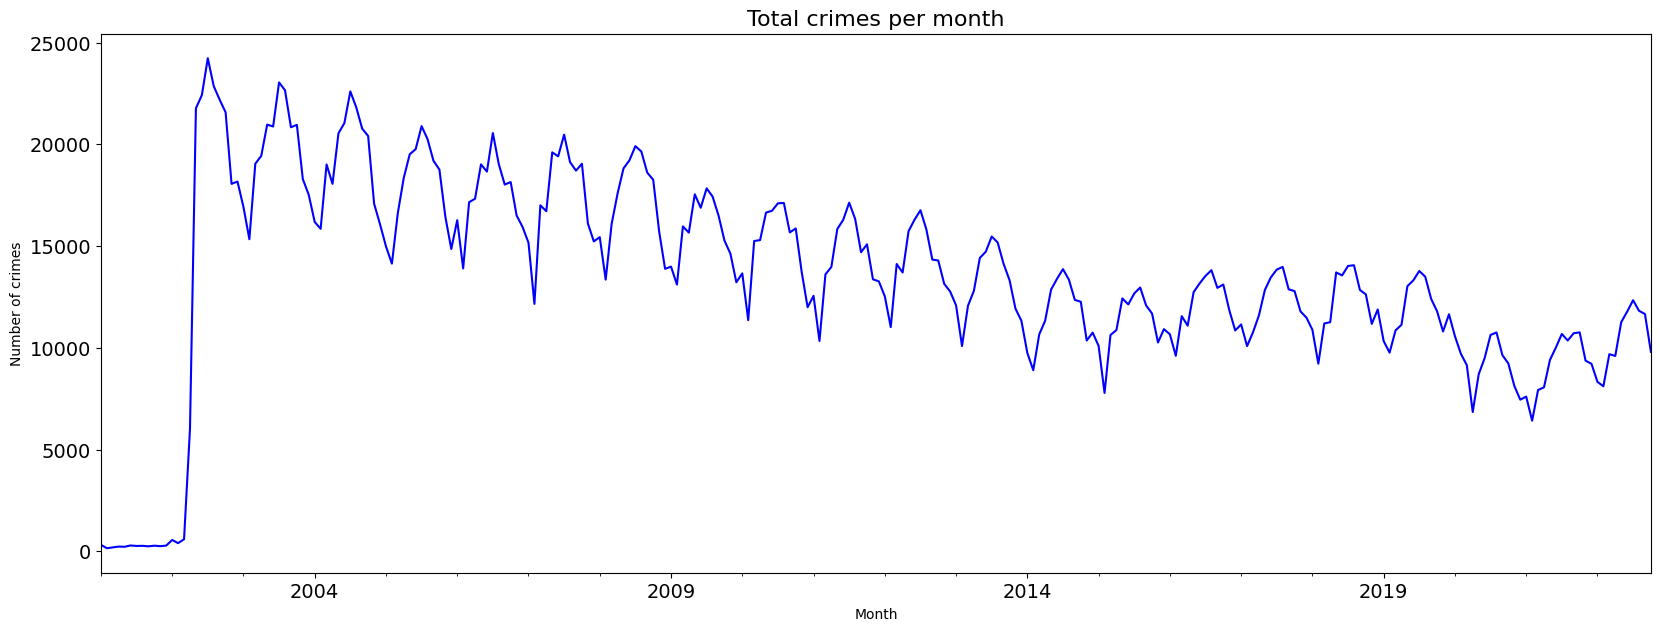

In [33]:
plt.figure(figsize=(20, 7))
resampled.size().plot(label = "Crimes per month", color = 'blue')

plt.title('Total crimes per month', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Number of crimes')
plt.tick_params(labelsize=14)


<AxesSubplot:xlabel='Counts', ylabel='Crime Type'>

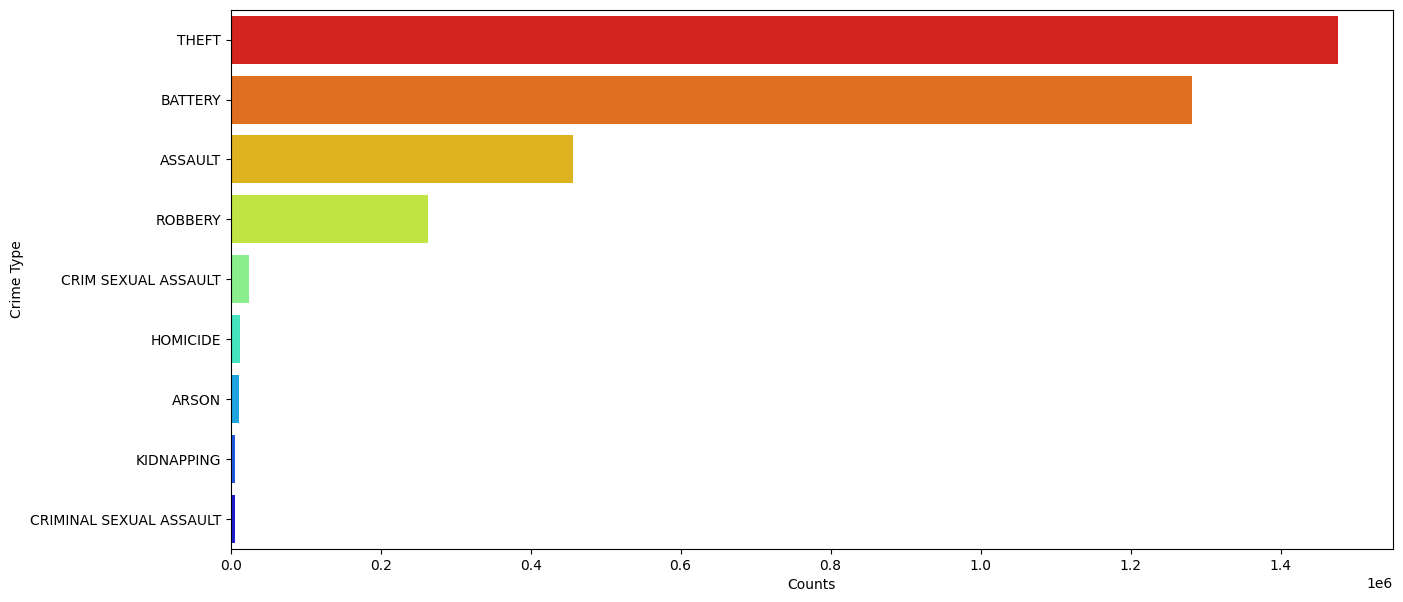

In [31]:
# plot the counts for each different type of crime
import seaborn as sns
crimes_data_by_type = pd.DataFrame({"Counts": crimes['Primary Type'].value_counts(), "Crime Type" : crimes['Primary Type'].value_counts().index})
plt.figure(figsize = (15, 7))
sns.barplot(y ="Crime Type", x = "Counts", data = crimes_data_by_type, palette="jet_r")